In this notebook, we'll be modeling maximising the fuel efficiecny of a car

# Model

The cars dynamics will follow a simple dynamical law:

$$
m\frac{dv(t)}{dt} = u(t) - \mu(t) - F_w(t)
$$



where
 - $u(t)$ is the force that is generated by the engine
 - $\mu(t)$ is the resitance force
 - $v(t)$ is the velocity of the car
 - $F_w(t)$ is the wind force
 - $m$ is the mass of the car

The car will have a cruise control setting, $v_{s}$. In order to reach this setting, the car is free to control the acceleraation u(t). 

The resitance force is made up of rolling friction and aerodynamic drag:

$$
\mu(t) = k_0(1-\exp^{-v(t)})+k_1v(t)^2
$$

The amount of instantaneous fuel burn, $\zeta(t)$, of the car is proportional to $u(t)$:

$$
\zeta(t) = \alpha_0 + \alpha_1 u(t)
$$
 
where $\alpha_0$ can be interpreted as the idle fuel burn. 

# Control Objective

The control objective is to control $u(t)$ such that the velocity is $v_s$


# Strategic optimisation

As a driver, the best speed will be the speed that maximises intergated fuel efficiency, $\int_0^T \eta(t) dt$. More formally, $\eta(t)$ is defined as the amount of fuel burned per unit distance travelled. We can derive the equation of this over a finite time horizon, $T$, and take the limit as $T$-> 0 to obtain the instantaneous value:

$$
\eta(t) =\lim_{T->0} \frac{\int_0^T \zeta(t) dt}{\int_0^Tv(t)dt} = \frac{\zeta(t)}{v(t)}
$$

For the special case of constant speed at $v_s$ and constant head wind, $F_w(t) = H$ then we can derive the following expression for $\eta(t)$



$$
\eta(t) =\frac{\alpha_0 + \alpha_1 u(t)}{v_s}\\
=\frac{\alpha_0 + \alpha_1 (\mu(t) + F_w(t)) }{v_s}\\
=\frac{\alpha_0 + \alpha_1 (k_0(1-\exp^{-v(t)})+k_1v_s^2 + H) }{v_s}\\
\approx \frac{\alpha_0 + \alpha_1 (k_0+k_1v_s^2 + H) }{v_s}\\
=\frac{\alpha_0 + \alpha_1(k_0+H) + \alpha_1k_1v_s^2) }{v_s} \\
=\frac{\alpha_0 + \alpha_1(k_0+H) }{v_s} + \alpha_1k_1v_s
$$


The following expression is minimised at:

$$
\eta_{min} = \sqrt{\frac{\alpha_0 + \alpha_1(k_0+H)}{\alpha_1k_1}}
$$

# Problem

The problem though is that we only know nominal values of $\alpha_0$ and $\alpha_1$, which may change as the car gets older. Additionally, $k_0$ and $F_w(t)$ change dynamically with road and weather conditions. $k_1$ will may also change with the shape of the car (if it gets a dent or some kind of body shape alteration). 

As a driver, my objective is to minimise overall fuel consumption. Theoretically if I could predict the road condition ahead of time, then I would be able to adjust my cruising speed set point to accomodate. 

This is what this notebook will explore. 



# Libraries

In [497]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation

%matplotlib notebook

# Setting up model and testing it

In [498]:
# Defining the constants

a_0 = 0 # assume that fuel burn and force are 1-1 correlated
a_1 = 1
m = 500 # kg # car is half a ton
k0 = 50
k1 = k0/450


In [499]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))

k1 = model.set_variable(var_type='_tvp', var_name='friction', shape=(1, 1))
fw = model.set_variable(var_type='_tvp', var_name='wind', shape=(1, 1))
acc = model.set_variable(var_type='_u', var_name='acc', shape=(1,1))

x_next = vertcat(x[1], acc/m - (k0*(1-exp(-x[1])) + k1*x[1]**2)/m - fw/m)
model.set_rhs('x',x_next)
model.setup()

In [500]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    tvp_template['wind'] = 0*np.random.normal(0,10)
    tvp_template['friction'] = k0/450
    return tvp_template

simulator.set_tvp_fun(tvp_fun)
simulator.setup()

In [501]:
simulator.x0 = np.array([0,0])

In [502]:
for i in range(250):
    if i < 15:
        u0 = np.ones((1,1))*900
    else: 
        u0 = np.zeros((1,1))
    simulator.make_step(u0)

<IPython.core.display.Javascript object>


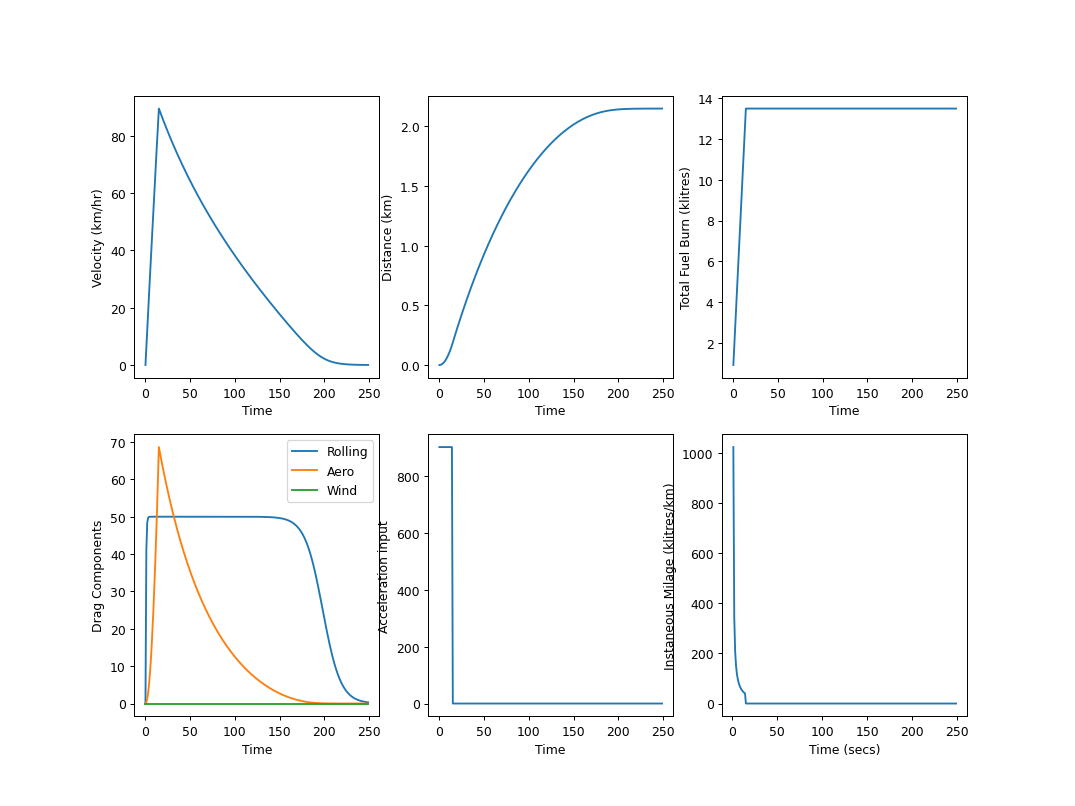

In [503]:
def plot_car_trajectory(simulator):
    fig,ax = plt.subplots(2,3, figsize=(12, 9))
    states_sim = simulator.data['_x']
    ax[0,0].plot(simulator.data['_time'],states_sim[:,1]*3.6)
    ax[0,0].set_xlabel("Time")
    ax[0,0].set_ylabel("Velocity (km/hr)")    
    
    dist = states_sim[:,0]/1000
    ax[0,1].plot(simulator.data['_time'],dist)
    ax[0,1].set_xlabel("Time")
    ax[0,1].set_ylabel("Distance (km)")    
    
    ax[1,0].plot(simulator.data['_time'],k0*(1-exp(-states_sim[:,1])),label = "Rolling")
    k1 = simulator.data['_tvp'][:,0]
    wind = simulator.data['_tvp'][:,1]
    ax[1,0].plot(simulator.data['_time'],k1*states_sim[:,1]**2,label = "Aero")
    ax[1,0].plot(simulator.data['_time'],wind,label = "Wind")
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Drag Components")    
    ax[1,0].legend(loc="upper right")
    
    ax[1,1].plot(simulator.data['_time'],simulator.data['_u'])
    ax[1,1].set_xlabel("Time")
    ax[1,1].set_ylabel("Acceleration input")     
    
    total_fuel_burn = np.cumsum(a_0 + a_1*simulator.data['_u'])/1000
    ax[0,2].plot(simulator.data['_time'],total_fuel_burn)
    ax[0,2].set_xlabel("Time")
    ax[0,2].set_ylabel("Total Fuel Burn (klitres)")     
    instaneous_milage = (total_fuel_burn[1:] - total_fuel_burn[0:-1]) / (dist[1:] - dist[0:-1])

    ax[1,2].plot(simulator.data['_time'][1:],instaneous_milage)
    ax[1,2].set_xlabel("Time (secs)")
    ax[1,2].set_ylabel("Instaneous Milage (klitres/km)")     

plot_car_trajectory(simulator)

# Using model with an "expert" controller

### Forward simulation

With the parameters above, the best speed for fuel efficiency is

$$
\eta_{min} = \sqrt{\frac{\alpha_0 + \alpha_1(k_0+H)}{\alpha_1k_1}} = \sqrt{\frac{k_0}{k_1}}  =  \sqrt{450} = 21 \approx 76 km/hr
$$

Let's use a basic controller to control the accelerator get up to this speed

In [504]:
def expert_controller(simulator,target_vel):
    current_distance = simulator.data['_x'][-1,0]
    current_velocity = simulator.data['_x'][-1,1]
    current_force = simulator.data['_u'][-1]
    if current_velocity < target_vel and current_force == 0:
        u0 = (150 + 1)*np.ones((1,1))
    elif current_velocity < target_vel and current_force > 0:
        u0 = (current_force + 1)*np.ones((1,1))
    else: 
        u0 = 0*np.ones((1,1))
    return u0

In [505]:
v_s = np.sqrt(450)
simulator.reset_history()
simulator.x0 = np.array([0,0])
for i in range(450):
    simulator.make_step(u0)
    u0 = expert_controller(simulator,v_s)

<IPython.core.display.Javascript object>


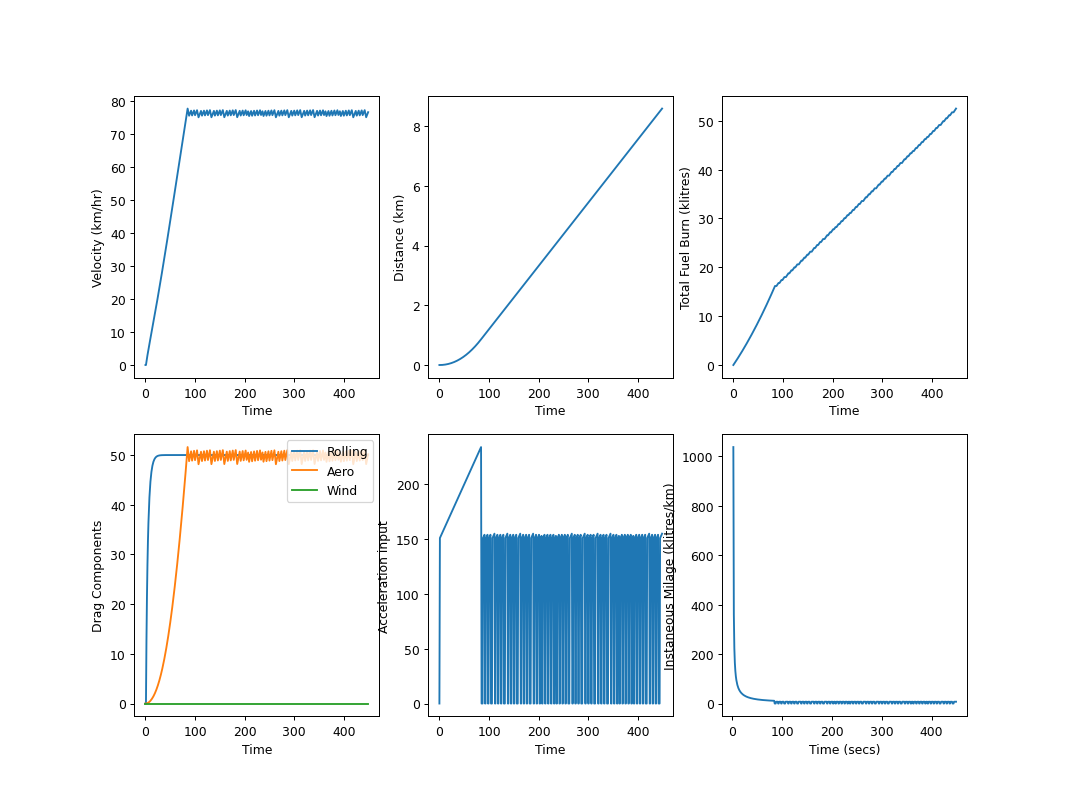

C:\Users\Ric Porteous\AppData\Local\Temp\ipykernel_20856\3535050911.py:30: RuntimeWarning: divide by zero encountered in divide
  instaneous_milage = (total_fuel_burn[1:] - total_fuel_burn[0:-1]) / (dist[1:] - dist[0:-1])


In [506]:
plot_car_trajectory(simulator)

### Now let's try to measure the friction 

In [507]:
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import Adam

In [508]:
class CarApproximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh(),l1_init = 1.0):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        
        # Register the other paramter
        #self.l1 = nn.Parameter(torch.tensor([l1_init], requires_grad=True).float())
        #self.register_parameter("l1",self.l1)
        
        for i in range(len(self.middle_layers)-1):
            nn.init.xavier_normal_(self.middle_layers[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.middle_layers[i].bias.data)   
    
    
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
PINN = CarApproximator(2,2)

In [509]:
class Friction_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        #self.relu = nn.LeakyReLU(inplace = True)

        for i in range(len(self.middle_layers)-1):
            nn.init.xavier_normal_(self.middle_layers[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.middle_layers[i].bias.data)   
    
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
Fapprox = Friction_approximator(2,3)

In [510]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

In [511]:
def calc_de_loss(nn,rr,t_col,u):
    de_loss = m*df(nn,t_col,1) - (u - (f(rr,t_col)*(1-torch.exp(-f(nn,t_col)))+ k0/450*f(nn,t_col)*f(nn,t_col) )) 
    return de_loss

def calc_bc_loss(nn,rr,t_data,vel_data):
    bc_loss = f(nn,t_data) - vel_data
    return bc_loss

def calc_ic_loss(nn,ic):
    ic_loss = f(nn,torch.tensor([[0.0]])) - ic
    return ic_loss
    

def compute_loss(nn,rr,t_col,t_data,f_data):
    
    vel_data = f_data[:,1].view(-1,1)
    u = f_data[:,2].view(-1,1)
    
    de_loss = calc_de_loss(nn,rr,t_col,u)
    bc_loss = calc_bc_loss(nn,rr,t_data,vel_data)
    ic_loss = calc_ic_loss(nn,0.0)
    final_loss = 0.01*de_loss.pow(2).mean()+bc_loss.pow(2).mean() + ic_loss.pow(2).mean()
    return final_loss

def optimise(optimiser,nn,rr,t_col,t_data,f_data):
    optimiser.zero_grad()
    loss = compute_loss(nn,rr,t_col,t_data,f_data)
    loss.backward()
    optimiser.step()
    return loss

In [512]:
lr = 0.01
epochs = 10000
PINN = CarApproximator(2,10)
F_approx = Friction_approximator(2,3)
learnable_params = list(PINN.parameters())  + list(F_approx.parameters())
pi_optimizer = Adam(learnable_params, lr=lr)

In [513]:
t_interior = torch.from_numpy(simulator.data['_time']).float()
sensor_data = torch.from_numpy(np.hstack((simulator.data['_x'],simulator.data['_u']))).float()
t_collocation =  t_interior
t_collocation.requires_grad = True

In [514]:
batch_size = 128
epochs = 2000
loss_vector = []
iteration_vector =[]
for i in range(epochs):
    permutation = torch.randperm(t_interior.size()[0])
    for j in range(0,t_interior.size()[0],batch_size):
        indices = permutation[j:j+batch_size]
        loss = optimise(pi_optimizer,PINN,F_approx,t_collocation[indices],t_interior[indices],sensor_data[indices])
    loss_vector.append(loss.detach().numpy())
    iteration_vector.append(i)
    if i % 100==0:
        full_loss = compute_loss(PINN,F_approx,t_collocation,t_interior,sensor_data)
        print(f"Epoch {i}: Loss: {full_loss.detach().numpy()}")


Epoch 0: Loss: 546.5339965820312
Epoch 100: Loss: 54.231693267822266
Epoch 200: Loss: 50.29987335205078
Epoch 300: Loss: 47.54697036743164
Epoch 400: Loss: 45.50947570800781
Epoch 500: Loss: 44.817317962646484
Epoch 600: Loss: 44.1639518737793
Epoch 700: Loss: 44.01383590698242
Epoch 800: Loss: 43.894508361816406
Epoch 900: Loss: 45.26747512817383
Epoch 1000: Loss: 43.847476959228516
Epoch 1100: Loss: 44.143943786621094
Epoch 1200: Loss: 43.94715881347656
Epoch 1300: Loss: 43.9577522277832
Epoch 1400: Loss: 43.77830505371094
Epoch 1500: Loss: 43.77911376953125
Epoch 1600: Loss: 43.83129119873047
Epoch 1700: Loss: 44.18840026855469
Epoch 1800: Loss: 44.64714431762695
Epoch 1900: Loss: 45.19489669799805


<IPython.core.display.Javascript object>


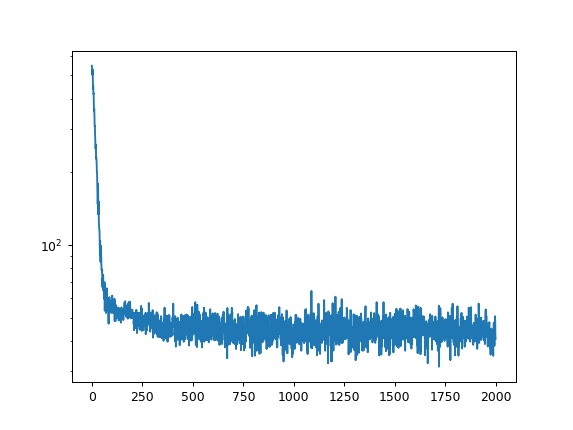

In [515]:
plt.figure()
plt.plot(iteration_vector,loss_vector)
plt.yscale('log')

<IPython.core.display.Javascript object>


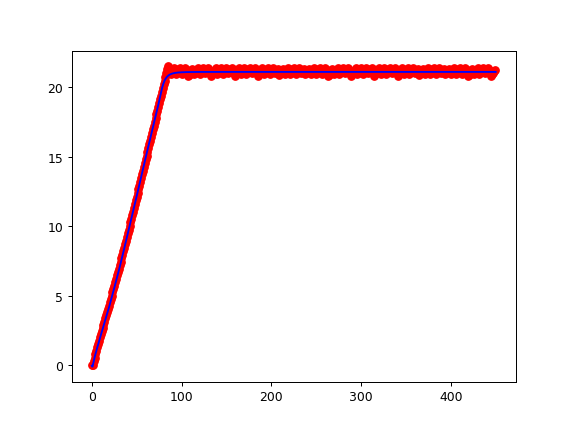

In [516]:
plt.figure()
t_data_domain = torch.linspace(0, 450, steps=1000).view(-1, 1)
with torch.no_grad():
    vel_prediction = PINN(t_data_domain).numpy()

plt.plot(t_interior.detach().numpy(),sensor_data.detach().numpy()[:,1],'or')
plt.plot(t_data_domain,vel_prediction,'b-')

<IPython.core.display.Javascript object>


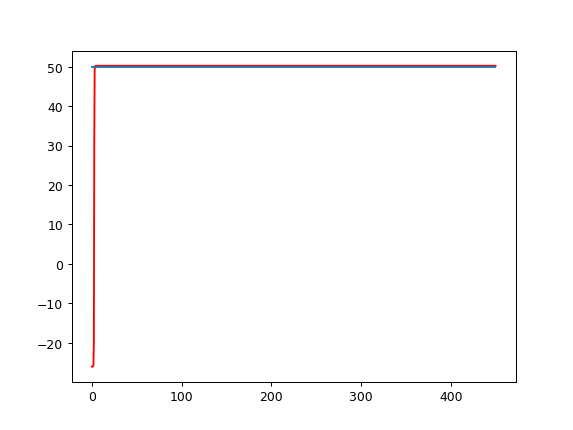

In [517]:
plt.figure()
# NOw interrogate the R approximator
t_data_domain = torch.linspace(0, 450, steps=1000).view(-1, 1)
with torch.no_grad():
    r_prediction = F_approx(t_data_domain).numpy()

plt.plot(t_data_domain,r_prediction,'r')
plt.plot( [simulator.data._time[0], simulator.data._time[-1] ], [k0,k0],'-')

## Relative error between the different components

In [521]:
vel_data = sensor_data[:,1].view(-1,1)
u = sensor_data[:,2].view(-1,1)
de_loss = calc_de_loss(PINN,F_approx,t_collocation,u)
bc_loss = calc_bc_loss(PINN,F_approx,t_interior,vel_data)
ic_loss = calc_ic_loss(PINN,0.0)

In [524]:
print(bc_loss.pow(2).mean()) 
print(0.01*de_loss.pow(2).mean())
print(ic_loss.pow(2).mean())

tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(43.8632, grad_fn=<MulBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)


<IPython.core.display.Javascript object>


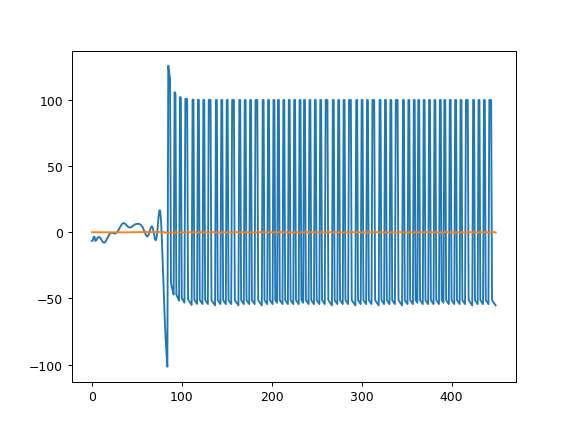

In [523]:
plt.figure()
plt.plot(de_loss.detach().numpy())
plt.plot(bc_loss.detach().numpy())